# GOOGL stock 'Close' value prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [30, 10]
plt.rcParams["figure.dpi"] = 250
plt.style.use('seaborn-notebook')
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import ccxt
import exchange_poloniex as expx

## Load Poloniex data

In [3]:
# expx.save_df(days_back = 90)

In [4]:
df = expx.load_df()
df.head()

,open,high,close
0,11429.0,11430.0,11367.0
1,11367.0,11482.0,11362.0
2,11361.0,11362.0,11355.0
3,11355.0,11408.0,11408.0
4,11408.0,11413.0,11413.0


## Updated load_data function from lstm.py, configured to accept any amount of features.
## It is set to calculate the last feature as a result.

In [5]:
def test_train_prep(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


## Building model functions

In [6]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

## Setting X and Y for training and testing

In [7]:
window = 10
X_train, y_train, X_test, y_test = test_train_prep(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (7766, 10, 3)
y_train (7766,)
X_test (863, 10, 3)
y_test (863,)


In [8]:
X_train[0]

array([[ 11429.,  11430.,  11367.],
       [ 11367.,  11482.,  11362.],
       [ 11361.,  11362.,  11355.],
       [ 11355.,  11408.,  11408.],
       [ 11408.,  11413.,  11413.],
       [ 11364.,  11400.,  11365.],
       [ 11378.,  11564.,  11454.],
       [ 11510.,  11510.,  11510.],
       [ 11510.,  11511.,  11475.],
       [ 11470.,  11473.,  11426.]])

## Loading the model sequence structure

In [23]:
model = build_model([3,window,1])
# model = build_model2([3,window,1])

Compilation Time :  0.020554780960083008


## Executing the model & RMS/RMSE results

In [25]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    nb_epoch=50,
    validation_split=0.1,
    verbose=2)

Train on 6989 samples, validate on 777 samples
Epoch 1/50
 - 2s - loss: 42323740.8917 - acc: 0.0000e+00 - val_loss: 13283767.9485 - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: 42321010.1560 - acc: 0.0000e+00 - val_loss: 13282176.6422 - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: 42318265.2814 - acc: 0.0000e+00 - val_loss: 13280582.8185 - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: 42315210.8296 - acc: 0.0000e+00 - val_loss: 13278989.5714 - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: 42312552.7017 - acc: 0.0000e+00 - val_loss: 13277399.8417 - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: 42310037.6134 - acc: 0.0000e+00 - val_loss: 13275808.1004 - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: 42307284.6851 - acc: 0.0000e+00 - val_loss: 13274211.2767 - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: 42304322.3105 - acc: 0.0000e+00 - val_loss: 13272622.4530 - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: 42301820.4916 - acc: 0.0000e+00 - val_loss: 13271029.6409 - val_acc: 0.0000e+00
Epoch 10

In [26]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 39289163.80 MSE (6268.11 RMSE)
Test Score: 30518429.20 MSE (5524.35 RMSE)


In [46]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict_on_batch(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

0 4016.0 14.3877 278.127549086 4001.61231232
1 4045.0 14.3877 280.143161368 4030.61231232
2 4005.0 14.3877 277.363006496 3990.61231232
3 4038.0 14.3877 279.656634265 4023.61231232
4 4042.0 14.3877 279.934649752 4027.61231232
5 4064.0 14.3877 281.463734932 4049.61231232
6 4060.0 14.3877 281.185719445 4045.61231232
7 4088.0 14.3877 283.131827854 4073.61231232
8 4114.0 14.3877 284.938928521 4099.61231232
9 4101.0 14.3877 284.035378188 4086.61231232
10 4143.0 14.3877 286.954540803 4128.61231232
11 4213.0 14.3877 291.819811828 4198.61231232
12 4267.0 14.3877 295.573020904 4252.61231232
13 4325.0 14.3877 299.604245467 4310.61231232
14 4344.0 14.3877 300.924819031 4329.61231232
15 4347.0 14.3877 301.133330647 4332.61231232
16 4369.0 14.3877 302.662415826 4354.61231232
17 4213.0 14.3877 291.819811828 4198.61231232
18 4249.0 14.3877 294.321951212 4234.61231232
19 4220.0 14.3877 292.30633893 4205.61231232
20 4266.0 14.3877 295.503517032 4251.61231232
21 4293.0 14.3877 297.38012157 4278.61231232


608 5269.0 14.3877 365.215900432 5254.61231232
609 5200.0 14.3877 360.420133279 5185.61231232
610 5171.0 14.3877 358.404520997 5156.61231232
611 5177.0 14.3877 358.821544228 5162.61231232
612 5160.0 14.3877 357.639978407 5145.61231232
613 5198.0 14.3877 360.281125535 5183.61231232
614 5200.0 14.3877 360.420133279 5185.61231232
615 5184.0 14.3877 359.30807133 5169.61231232
616 5184.0 14.3877 359.30807133 5169.61231232
617 5123.0 14.3877 355.068335151 5108.61231232
618 5165.0 14.3877 357.987497766 5150.61231232
619 5156.0 14.3877 357.36196292 5141.61231232
620 5225.0 14.3877 362.157730073 5210.61231232
621 5158.0 14.3877 357.500970664 5143.61231232
622 5209.0 14.3877 361.045668125 5194.61231232
623 5215.0 14.3877 361.462691355 5200.61231232
624 5215.0 14.3877 361.462691355 5200.61231232
625 5228.0 14.3877 362.366241689 5213.61231232
626 5227.0 14.3877 362.296737817 5212.61231232
627 5315.0 14.3877 368.413078534 5300.61231232
628 5341.0 14.3877 370.2201792 5326.61231232
629 5338.0 14.3877

In [49]:
for i in range(len(X_test)):
    print(model.predict_on_batch(X_test[i]))

ValueError: Error when checking : expected lstm_3_input to have 3 dimensions, but got array with shape (10, 3)

## Predictions vs Real results

predicted [ 14.38768768] y_test 4016.0
predicted [ 14.38768768] y_test 4045.0
predicted [ 14.38768768] y_test 4005.0
predicted [ 14.38768768] y_test 4038.0
predicted [ 14.38768768] y_test 4042.0
predicted [ 14.38768768] y_test 4064.0
predicted [ 14.38768768] y_test 4060.0
predicted [ 14.38768768] y_test 4088.0
predicted [ 14.38768768] y_test 4114.0
predicted [ 14.38768768] y_test 4101.0
predicted [ 14.38768768] y_test 4143.0
predicted [ 14.38768768] y_test 4213.0
predicted [ 14.38768768] y_test 4267.0
predicted [ 14.38768768] y_test 4325.0
predicted [ 14.38768768] y_test 4344.0
predicted [ 14.38768768] y_test 4347.0
predicted [ 14.38768768] y_test 4369.0
predicted [ 14.38768768] y_test 4213.0
predicted [ 14.38768768] y_test 4249.0
predicted [ 14.38768768] y_test 4220.0
predicted [ 14.38768768] y_test 4266.0
predicted [ 14.38768768] y_test 4293.0
predicted [ 14.38768768] y_test 4349.0
predicted [ 14.38768768] y_test 4366.0
predicted [ 14.38768768] y_test 4328.0
predicted [ 14.38768768] 

predicted [ 14.38768768] y_test 5899.0
predicted [ 14.38768768] y_test 5781.0
predicted [ 14.38768768] y_test 5809.0
predicted [ 14.38768768] y_test 5534.0
predicted [ 14.38768768] y_test 5580.0
predicted [ 14.38768768] y_test 5450.0
predicted [ 14.38768768] y_test 5640.0
predicted [ 14.38768768] y_test 5549.0
predicted [ 14.38768768] y_test 5646.0
predicted [ 14.38768768] y_test 5565.0
predicted [ 14.38768768] y_test 5518.0
predicted [ 14.38768768] y_test 5520.0
predicted [ 14.38768768] y_test 5568.0
predicted [ 14.38768768] y_test 5545.0
predicted [ 14.38768768] y_test 5558.0
predicted [ 14.38768768] y_test 5544.0
predicted [ 14.38768768] y_test 5523.0
predicted [ 14.38768768] y_test 5570.0
predicted [ 14.38768768] y_test 5630.0
predicted [ 14.38768768] y_test 5638.0
predicted [ 14.38768768] y_test 5612.0
predicted [ 14.38768768] y_test 5557.0
predicted [ 14.38768768] y_test 5621.0
predicted [ 14.38768768] y_test 5574.0
predicted [ 14.38768768] y_test 5508.0
predicted [ 14.38768768] 

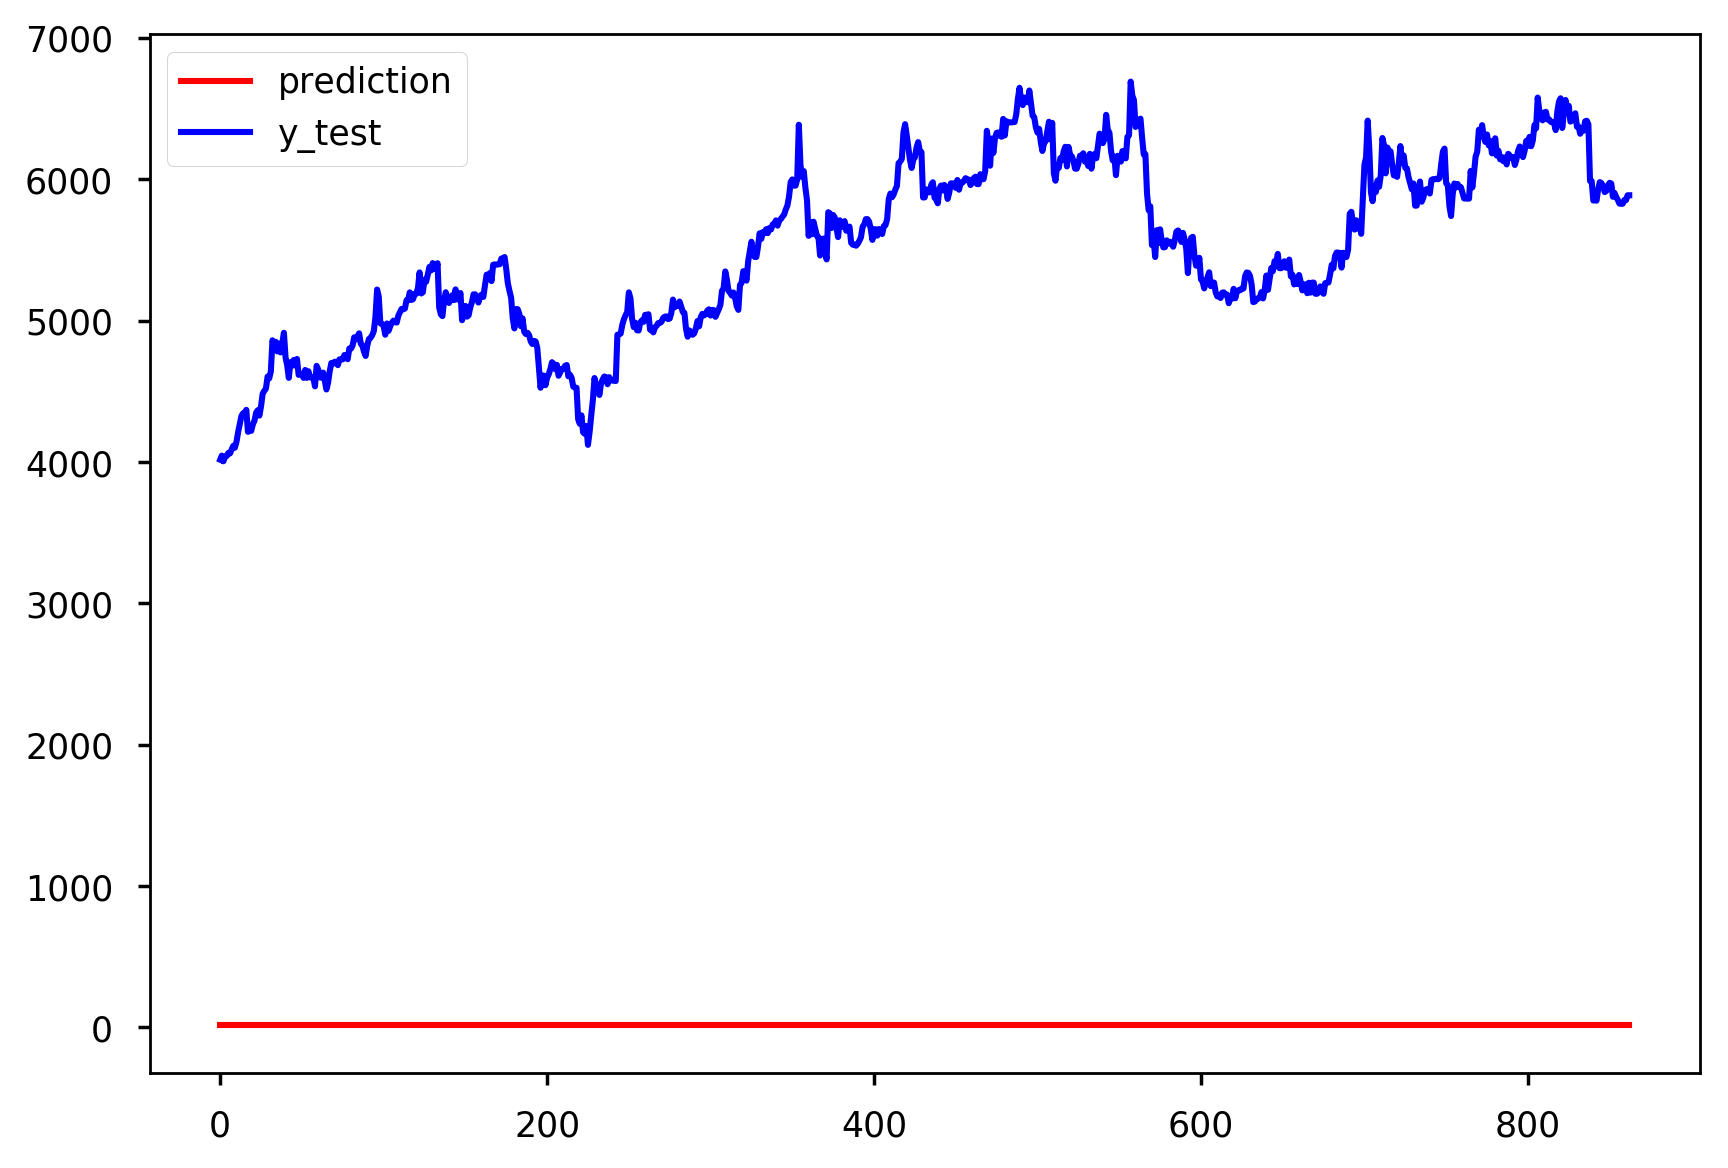

In [28]:
import matplotlib.pyplot as plt2

for i in range(len(p)):
    print('predicted', p[i], 'y_test', y_test[i])

plt2.plot(p, color='red', label='prediction')
plt2.plot(y_test, color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [16]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
#     print('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [33]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    print("AHHHHH")
    prediction_seqs = []
    print(len(data), prediction_len)
    for i in range(round(len(data)/prediction_len)-1):
        print(i)
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
            print(predicted)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [34]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [35]:
predictions = predict_sequence_full(model, X_test, 6)
# predictions = predict_sequences_multiple(model, X_test, 50, 50)
# print(predictions)

In [38]:
data = X_test
window_size = 50
prediction_len = 50
prediction_seqs = []
print(len(data), prediction_len)
for i in range(round(len(data)/prediction_len)-1):
    print(i)
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(prediction_len):
        print(j)
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        print(predicted)
    prediction_seqs.append(predicted)

863 50
0
0


TypeError: %i format: a number is required, not list

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

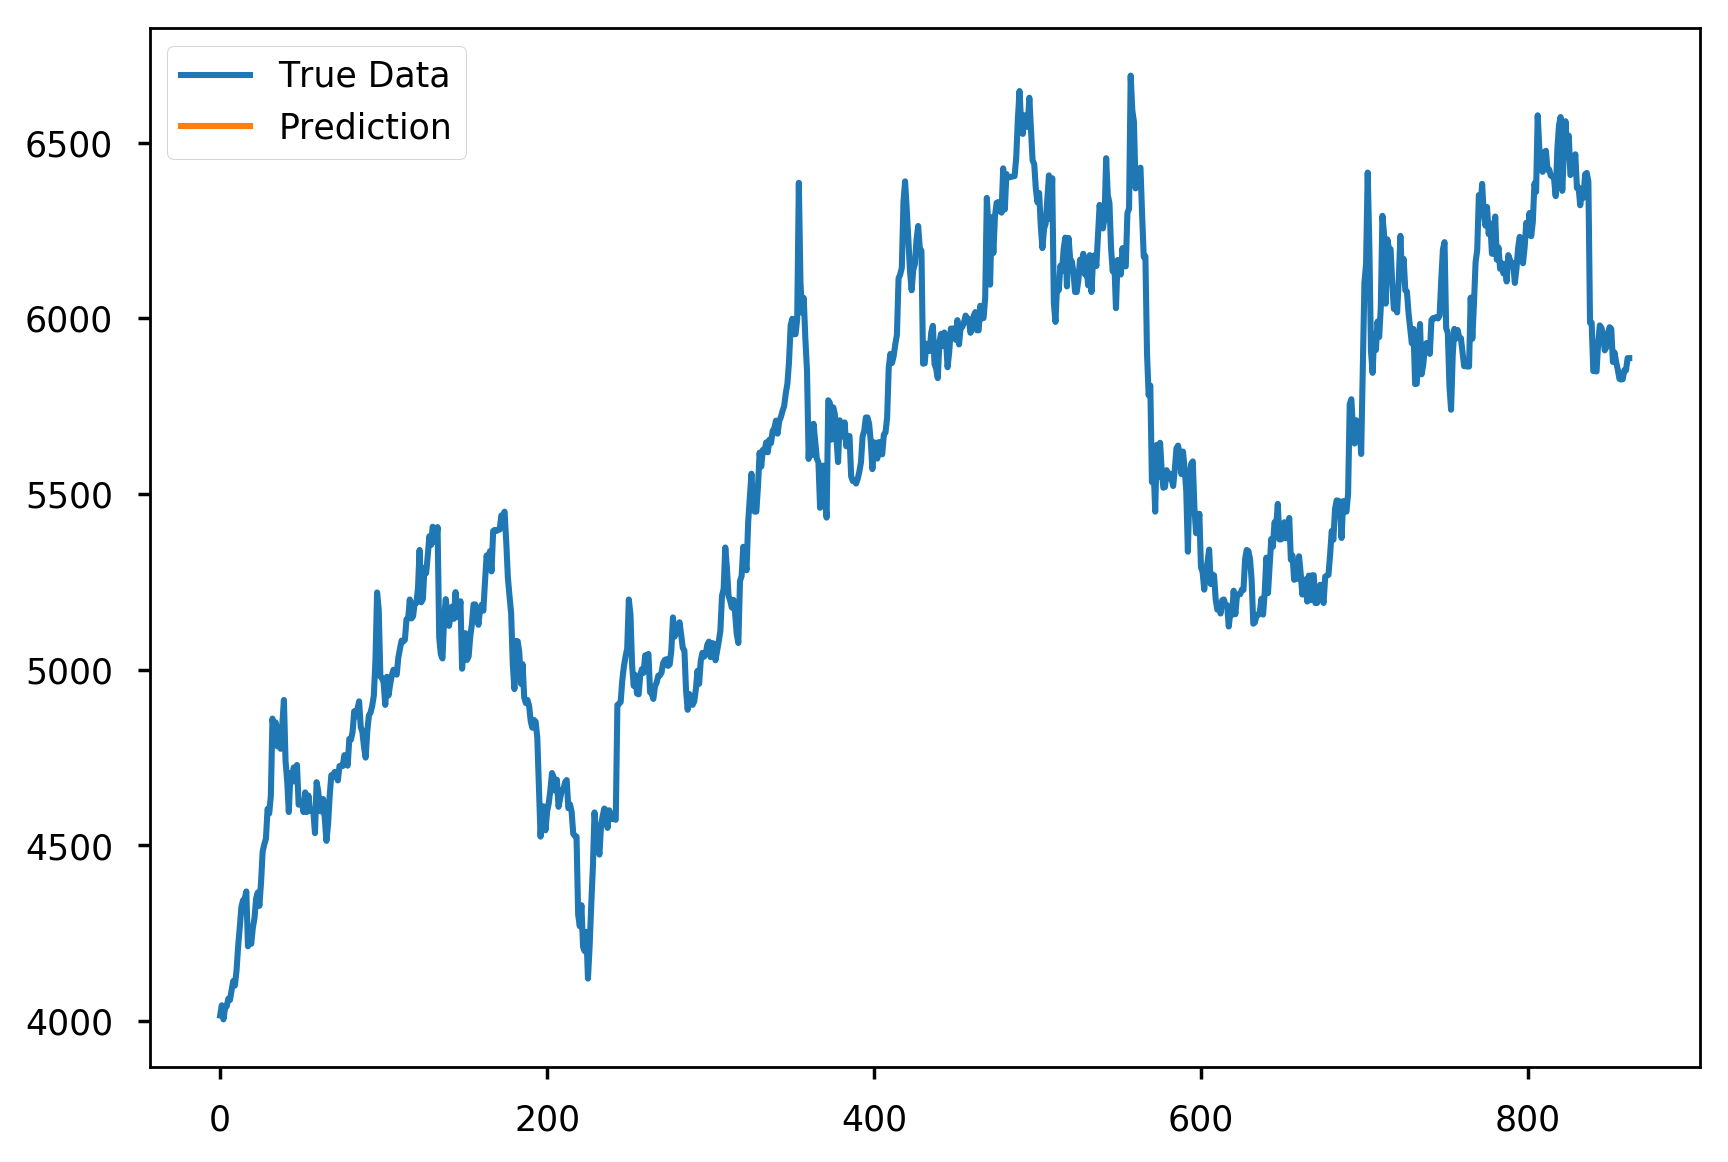

In [31]:
plot_results_multiple(predictions, y_test, 50)

In [32]:
print(predictions)

[14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688, 14.387688